In [2]:
# import all the libraries
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings

In [4]:
# Load Dataset
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
stores = pd.read_csv('stores.csv')
oil = pd.read_csv('oil.csv')
holidays_events = pd.read_csv('holidays_events.csv')

In [5]:
oil.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [6]:
#Handling missing values in oil prices
oil['dcoilwtico'] = oil['dcoilwtico'].interpolate(method='linear')

In [7]:
#merge dataset

train = train.merge(stores, on = 'store_nbr', how='left')
train = train.merge(oil, on = 'date', how = 'left')
train = train.merge(holidays_events, on = 'date', how = 'left')

In [8]:
train.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,type_x,cluster,dcoilwtico,type_y,locale,locale_name,description,transferred
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,False
1,1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,False
2,2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,False
3,3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,False
4,4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,False


In [9]:
#here we can see that our dataset merge with train dataset.

In [11]:
#convert date time column
train['date'] = pd.to_datetime(train['date'])
oil['date'] = pd.to_datetime(oil['date'])
holidays_events['date'] = pd.to_datetime(holidays_events['date'])

In [14]:
#Feature Engineering
train['day'] = train['date'].dt.day
train['week'] = train['date'].dt.isocalendar().week
train['month'] = train['date'].dt.month
train['year'] = train['date'].dt.year
train['day_of_week'] = train['date'].dt.dayofweek

In [15]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3054348 entries, 0 to 3054347
Data columns (total 21 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           int64         
 1   date         datetime64[ns]
 2   store_nbr    int64         
 3   family       object        
 4   sales        float64       
 5   onpromotion  int64         
 6   city         object        
 7   state        object        
 8   type_x       object        
 9   cluster      int64         
 10  dcoilwtico   float64       
 11  type_y       object        
 12  locale       object        
 13  locale_name  object        
 14  description  object        
 15  transferred  object        
 16  day          int32         
 17  week         UInt32        
 18  month        int32         
 19  year         int32         
 20  day_of_week  int32         
dtypes: UInt32(1), datetime64[ns](1), float64(2), int32(4), int64(4), object(9)
memory usage: 434.0+ MB


In [16]:
# Holiday & Event Features
train['is_holiday'] = train['type_y'].notna().astype(int)
train['is_weekend'] = (train['day_of_week'] >= 5).astype(int)
train['is_gov_payday'] = train.apply(
    lambda row:int(row['day'] in [15, row['date'].days_in_month]), axis=1
)
train['earthquake_impact'] = (train['date'] == '2016-04-16').astype(int)

In [18]:
#Rolling statistic & Features
train['sales_lag_7'] = train.groupby(['store_nbr', 'family'])['sales'].shift(7)
train['sales_lag_30'] = train.groupby(['store_nbr', 'family'])['sales'].shift(30)
train['rolling_mean_7'] = train.groupby(['store_nbr', 'family'])['sales'].rolling(7).mean().reset_index(level = [0,1], drop=True)
train['rolling_std_7'] = train.groupby(['store_nbr', 'family'])['sales'].rolling(7).std().reset_index(level = [0,1], drop=True)

In [20]:
#Store specific aggregation
store_avg_sales = train.groupby('store_nbr')['sales'].mean().rename('avg_store_sales')
train = train.merge(store_avg_sales, on = 'store_nbr', how = 'left')

## Exploratory Data Analysis (EDA)

AttributeError: Text.set() got an unexpected keyword argument 'rotational'

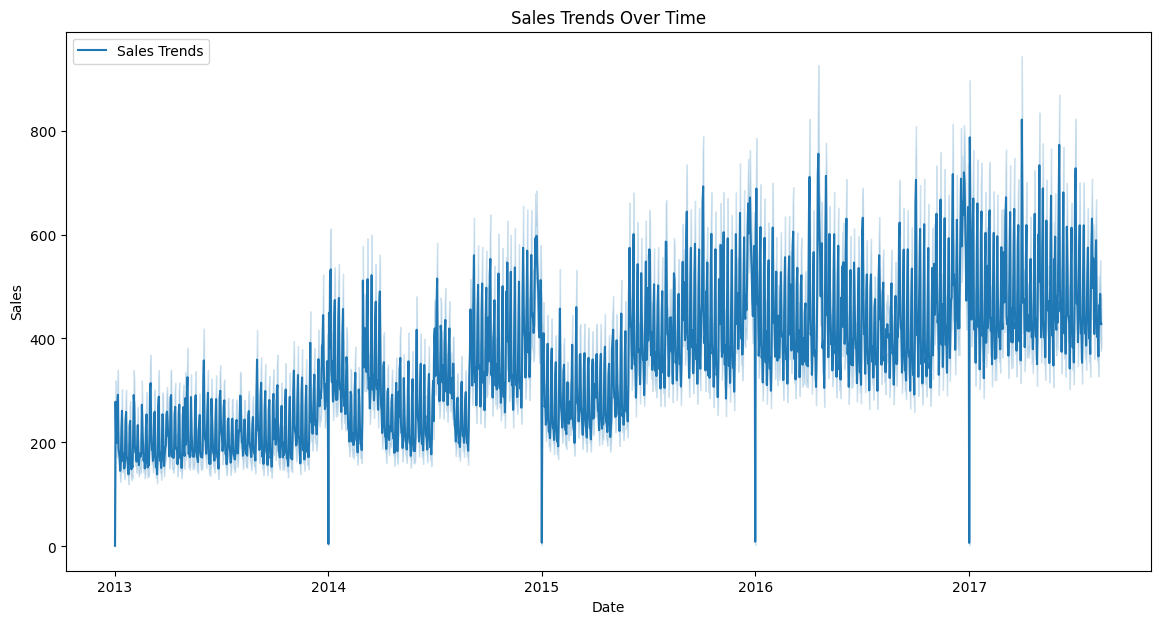

In [21]:
plt.figure(figsize=(14, 7))
sns.lineplot(x = 'date', y = 'sales' , data = train, label = 'Sales Trends')
plt.title('Sales Trends Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.xticks(rotational=40)
plt.legend()
plt.show()

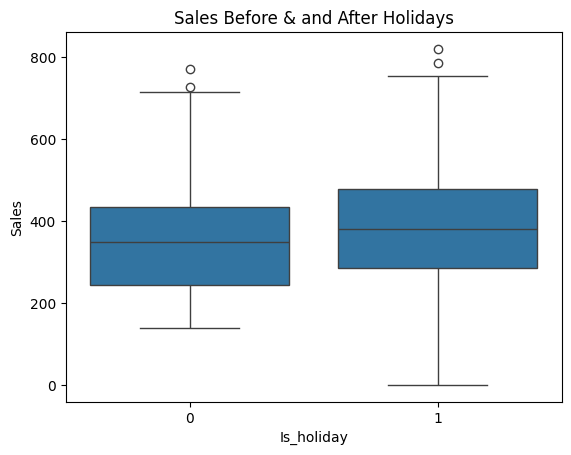

In [22]:
#Analysis pre/post holiday and promotion sales
holiday_sales = train.groupby(['date','is_holiday'])['sales'].mean().reset_index()
sns.boxplot(x = 'is_holiday', y = 'sales', data=holiday_sales)
plt.title('Sales Before & and After Holidays')
plt.xlabel('Is_holiday')
plt.ylabel('Sales')
plt.show()

Correlation between Sales & Oil Price:
               sales  dcoilwtico
sales       1.000000   -0.079009
dcoilwtico -0.079009    1.000000


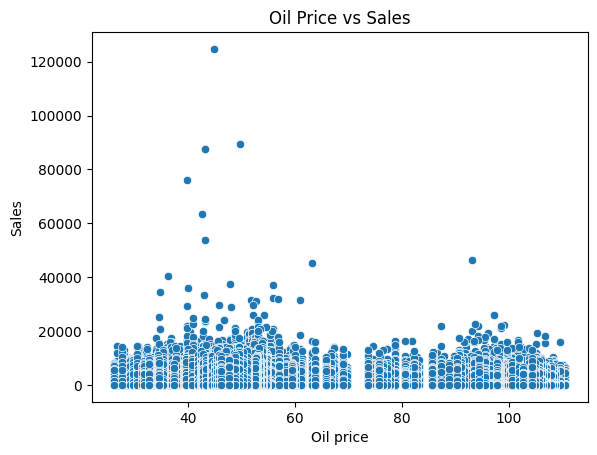

In [23]:
# Check corelation between Oil Price and Sales
correlation = train[['sales', 'dcoilwtico']].corr()
print("Correlation between Sales & Oil Price:")
print(correlation)
sns.scatterplot(x = 'dcoilwtico', y = 'sales', data = train)
plt.title('Oil Price vs Sales')
plt.xlabel('Oil price')
plt.ylabel('Sales')
plt.show() 

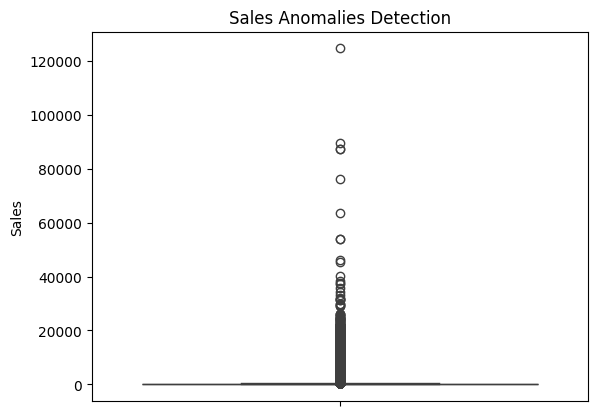

In [24]:
#Anamalies in data
sns.boxplot(y = 'sales', data=train)
plt.title('Sales Anomalies Detection')
plt.ylabel('Sales')
plt.show()

In [25]:
# Save dataset
train.to_csv('Processed_train1.csv', index=False)

print("Data Processing and Feature Engineering Completed")

Data Processing and Feature Engineering Completed


## Model Selection, Forecasting, and Evaluation

In [27]:
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
import warnings
warnings.filterwarnings("ignore")

In [29]:
#load dataset
train = pd.read_csv('Processed_train1.csv', parse_dates = ['date'], low_memory = False)

In [32]:
# Naive Forcasting
train['naive_forcasting'] = train.groupby(['store_nbr', 'family'])['sales'].shift(1)

In [33]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3054348 entries, 0 to 3054347
Data columns (total 31 columns):
 #   Column             Dtype         
---  ------             -----         
 0   id                 int64         
 1   date               datetime64[ns]
 2   store_nbr          int64         
 3   family             object        
 4   sales              float64       
 5   onpromotion        int64         
 6   city               object        
 7   state              object        
 8   type_x             object        
 9   cluster            int64         
 10  dcoilwtico         float64       
 11  type_y             object        
 12  locale             object        
 13  locale_name        object        
 14  description        object        
 15  transferred        object        
 16  day                int64         
 17  week               int64         
 18  month              int64         
 19  year               int64         
 20  day_of_week        int64

In [34]:
#Preparing training data
feature = ['day', 'week', 'month', 'year', 'day_of_week', 'is_holiday', 'is_weekend', 'is_gov_payday', 'earthquake_impact',
           'sales_lag_7', 'sales_lag_30', 'rolling_mean_7', 'rolling_std_7', 'avg_store_sales']

X = train[feature].dropna()
y = train.loc[X.index, 'sales']

In [35]:
#Split into training and validation sets
train_size = int(len(X) * 0.8)
X_train, X_val = X[:train_size], X[train_size:]
y_train, y_val = y[:train_size], y[train_size:]

In [36]:
y_train_sample = y_train.iloc[-10000:]

In [38]:
#Train ARIMA model
arima_model = ARIMA(y_train, order=(2,1,0))
arima_model_fit = arima_model.fit(low_memory = True)
arima_preds = arima_model_fit.forecast(steps = len(y_val))

In [42]:
random_forest = RandomForestRegressor(
    n_estimators = 50,
    max_depth = 10,
    n_jobs = -1,
    bootstrap = False,
    random_state = 42
)

X_sample, y_sample = X_train.sample(50000, random_state = 42), y_train.loc[X_train.sample(50000, random_state=42).index]
random_forest.fit(X_sample, y_sample)
random_preds = random_forest.predict(X_val)

In [43]:
random_forest.fit(X_sample, y_sample)

RandomForestRegressor(bootstrap=False, max_depth=10, n_estimators=50, n_jobs=-1,
                      random_state=42)

In [44]:
random_forest.predict(X_sample)

array([191.5412496 ,   3.24605501, 313.21990291, ..., 489.70811932,
        39.93198059,  15.44235662])

In [46]:
#Train XGBoost model
xgb_model = XGBRegressor(objective = 'reg:squarederror', n_estimator = 100, learning_rate = 0.1)
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_val)

In [48]:
#Evaluation Metrics
def eval_model(y_true, y_pred, model_name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{model_name} - RMSE: {rmse:.2f}, MAPE: {mape:.2%}, R2: {r2:.2f}")

print("Model Evaluation:")
if 'arima_preds' in locals():
    eval_model(y_val, arima_preds, "ARIMA")
else:
    print("Arima pridection not found")
if "random_forest" in locals():
    random_preds = random_forest.predict(X_val)
else:
    print("Random Forest model not trained")

eval_model(y_val, arima_preds, "ARIMA")
eval_model(y_val, random_preds, "Random Forest")
eval_model(y_val, xgb_preds, "XGBoost")

Model Evaluation:
ARIMA - RMSE: 1411.32, MAPE: 10195183152728408064.00%, R2: -0.06
ARIMA - RMSE: 1411.32, MAPE: 10195183152728408064.00%, R2: -0.06
Random Forest - RMSE: 431.90, MAPE: 975344682013655424.00%, R2: 0.90
XGBoost - RMSE: 307.43, MAPE: 728251545701144448.00%, R2: 0.95


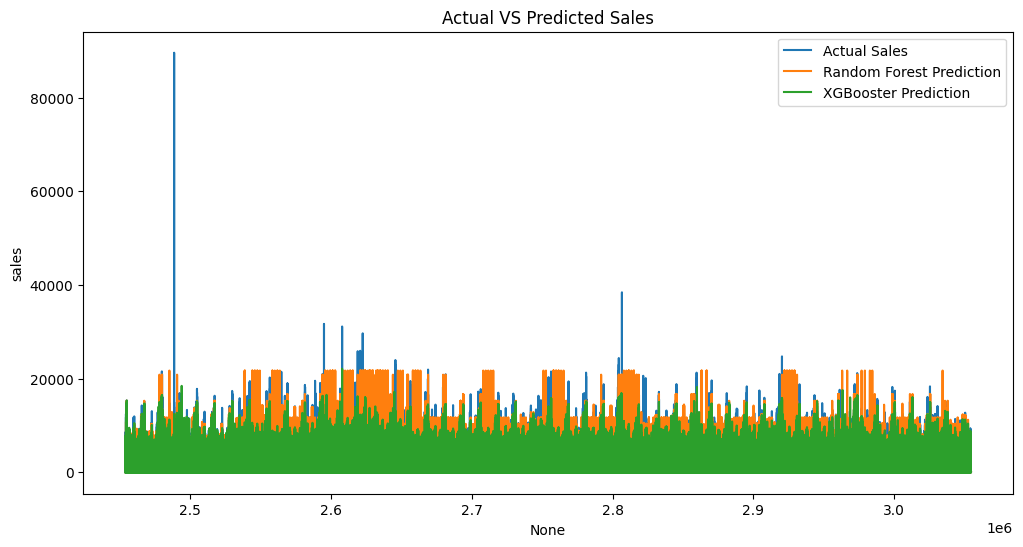

Model Built Successfull


In [52]:
#Visualization
plt.figure(figsize = (12,6))
sns.lineplot(x = y_val.index, y=y_val, label = "Actual Sales")
sns.lineplot(x = y_val.index, y=random_preds, label = "Random Forest Prediction")
sns.lineplot(x = y_val.index, y=xgb_preds, label = "XGBooster Prediction")   
plt.legend()
plt.title("Actual VS Predicted Sales")
plt.show()

print("Model Built Successfull")